In [111]:
import os
import ee
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, JOIN_STYLE

ee.Initialize()

In [2]:
# Load the crop mapping dwr data 

cm = gp.read_file("../shape/Crop__Mapping_2014.shp")
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs


In [ ]:
list(cm)

In [3]:
# Bar plot of of acreage by crop type in 2014
out = {}

for i in cm.DWR_Standa.unique():
    acreage = cm[cm.DWR_Standa == i]['Acres'].sum()
    out[i] = acreage*0.00404686 # acres to sq km

In [4]:
total = np.array(list(out.values())).sum()

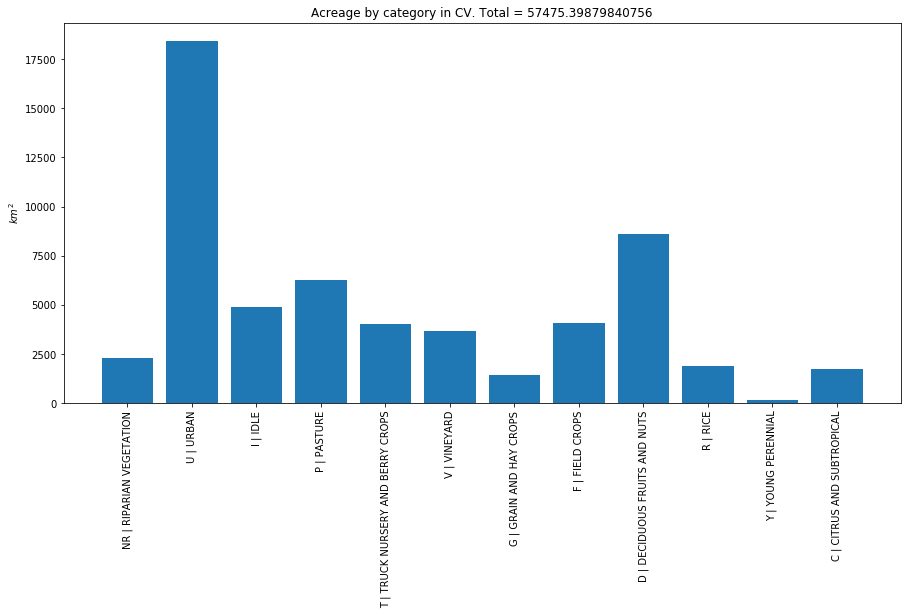

In [9]:
plt.figure(figsize=(15,7))
plt.bar(range(len(out)), out.values(), align='center')
plt.title("Acreage by category in CV. Total = {}".format(str(total)))
plt.xticks(range(len(out)), list(out.keys()),rotation='vertical')
plt.ylabel("$km^2$")
plt.show()

In [84]:
irr_dfs = []

for i in list(cm.DWR_Standa.unique())[4:6]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[7:]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)

T | TRUCK NURSERY AND BERRY CROPS
V | VINEYARD
F | FIELD CROPS
D | DECIDUOUS FRUITS AND NUTS
R | RICE
Y | YOUNG PERENNIAL
C | CITRUS AND SUBTROPICAL


In [ ]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(1, 1, 1)
cvsa.plot(ax=ax, color = "blue", alpha = 0.1)

for i in range(len(irr_dfs)):
    irr_dfs[i].plot(ax=ax)
    
plt.show()

In [166]:
t = dfs.buffer(0.001).unary_union

In [169]:
d  = gp.GeoDataFrame(geometry=gp.GeoSeries(t))

In [173]:
d.to_file("../shape/buf_001.shp")

In [179]:
d2  = gp.GeoDataFrame(geometry=gp.GeoSeries(d.simplify(0.01))) 

In [195]:
def gdf_to_ee_multipoly(gdf):

    lls = gdf.geometry.iloc[0]
    mps = [x for x in lls]
    multipoly = []

    for i in mps: 
        x,y = i.exterior.coords.xy
        coords = [list(zip(x,y))]
        multipoly.append(coords)

    return ee.Geometry.MultiPolygon(multipoly)


In [208]:
area = gdf_to_ee_multipoly(d2)

In [203]:
years = [x for x in range(2001, 2018)]
months = range(1,13)

In [205]:
data = {}

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['terra'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*24 ]

In [206]:
def get_data(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var]
    
    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        for month in months:
            r = get_data(dataset, year, month)
            monthly.append(r)
    
    print("wrapper complete")
    return monthly

In [ ]:
# Fetch all ET data - warning: takes very long
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])
# TODO: gldas, nldas

wrapper complete


In [ ]:
d.to_file("../shape/dwr_irrigated_ag_14.shp")